<a href="https://colab.research.google.com/github/Ngum12/DRIAN---Conflict-Events---Model-Training-and-Evaluation2/blob/main/Summative_Intro_to_ml_%5BNgum_Dieudonne_number%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PROJECT NAME: **DRIAN - Conflict Events Classification with/without Optimization**
* PROBLEM STATEMENT:

 1. In this project, we aim to classify conflict events using both classical ML algorithms and neural networks. We apply various optimization techniques (e.g., regularization, early stopping) to improve model performance and demonstrate how different hyperparameter settings can affect results.

# Optimization Techniques in Machine Learning






# Ngum's Notebook Structure

 1. Project Setup and Imports

 2. Load Dataset

 3. Data Preprocessing

 4. Train, Validation, and Test Split

 **5. Classical ML Models**


        * Logistic Regression

        * Support Vector Machine (SVM)
       
        * XGBoost
6. Simple Neural Network (No Optimization)

7. Optimized Neural Network

  
        * Single instance of an optimized NN

8. Five Instances of Optimized NN

       * Varying hyperparameters
9. Model Evaluation and Comparison

10. Saving and Loading Models

11. Making Predictions

12. Summary & Next Steps

# And finally a diagramatical display of their confusion matrix


## 1: Project Setup and Imports

In [3]:
# IMPORT LIBRARIES

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for classical ML models and utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import resample

# XGBoost for advanced tree-based modeling
!pip install xgboost -q
import xgboost as xgb

# TensorFlow/Keras for Neural Networks
!pip install tensorflow -q
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# For saving/loading classical models
import joblib

print("Setup complete!")


Setup complete!


# 2: Load Dataset
We read the CSV file containing the conflict event data.

A quick preview (via head()) helps verify that the file loaded correctly.


In [4]:
# LOAD DATASET

data = pd.read_csv('/content/Conflicts-afri_data. - Conflicts-afri_datahome - data_set-conflict.csv.csv')
print("Data loaded. Preview:")
data.head()

Data loaded. Preview:


<ipython-input-4-33a39a746622>:3: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/Conflicts-afri_data. - Conflicts-afri_datahome - data_set-conflict.csv.csv')


,GWNO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,ACTOR1,ACTOR_DYAD_ID,COUNTRY,ADMIN1,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,NOTES,FATALITIES
0,615,16ALG,16,01/02/1997,1997,1,Violence against civilians,GIA: Armed Islamic Group,636-1071,Algeria,Bordj Bou Arreridj,Mechta Larbaa,36.0466,5.1317,1,www.algeria-watch.org,1 February: 7 citizens of a farming estate (Ha...,7
1,615,39ALG,39,02/06/1997,1997,1,Remote violence,GIA: Armed Islamic Group,636-1071,Algeria,Alger,Algiers,36.7525,3.042,1,www.algeria-watch.org,2 June: Explosion of a bomb in the working-cla...,10
2,615,45ALG,45,02/07/1997,1997,1,Violence against civilians,GIA: Armed Islamic Group,636-1071,Algeria,Mascara,Chabet Larbaa,35.0961,0.2078,1,www.algeria-watch.org,2 July: 4 people of the same family were kille...,4
3,615,77ALG,77,02/09/1997,1997,1,Violence against civilians,GIA: Armed Islamic Group,636-1071,Algeria,Mascara,Ouled Larbi,35.4156,0.2825,1,www.algeria-watch.org,2 September: 22 citizen including 10 children ...,22
4,615,87ALG,87,02/10/1997,1997,1,Violence against civilians,GIA: Armed Islamic Group,636-1071,Algeria,Medea,Chaba Melaha,36.0101,2.8989,1,www.algeria-watch.org,2 Oct 1997: 37 people were killed in the villa...,37


# 3: Data Preprocessing

  1. Converting date columns to a proper datetime format allows extracting features like month/day.

  2. Ensuring LATITUDE and LONGITUDE are numeric is crucial for any geospatial analysis.

  3. Filling missing values ensures the model doesn’t break on NaNs.

  4. Label encoding transforms categorical data into numeric codes.

  5. Standard scaling numeric columns can help certain models (e.g., SVM, neural networks) converge more quickly.

In [5]:
# DATA PREPROCESSING

# 1. Convert EVENT_DATE to datetime and extract month/day
data['EVENT_DATE'] = pd.to_datetime(data['EVENT_DATE'], errors='coerce')
data['MONTH'] = data['EVENT_DATE'].dt.month
data['DAY'] = data['EVENT_DATE'].dt.day

# 2. Convert LATITUDE and LONGITUDE to numeric
data['LATITUDE'] = pd.to_numeric(data['LATITUDE'], errors='coerce')
data['LONGITUDE'] = pd.to_numeric(data['LONGITUDE'], errors='coerce')

# 3. Handle missing values (forward-fill as an example)
data.fillna(method='ffill', inplace=True)

# 4. Label encode categorical columns
categorical_cols = ['EVENT_TYPE', 'ACTOR1', 'ACTOR_DYAD_ID', 'COUNTRY', 'ADMIN1', 'LOCATION', 'SOURCE']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# 5. (Optional) Scale numeric features
numeric_cols = ['YEAR', 'TIME_PRECISION', 'LATITUDE', 'LONGITUDE', 'GEO_PRECISION', 'FATALITIES', 'MONTH', 'DAY']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

print("Data preprocessing complete. Data shape:", data.shape)

<ipython-input-5-244ca763c987>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Data preprocessing complete. Data shape: (140580, 20)


# 4: Train, Validation, and Test Split.

  1. We allocate 60% of the data to training, 20% to validation, and 20% to testing.
  
  2. The validation set helps tune hyperparameters without biasing the final test results.

In [6]:
# SPLIT DATA INTO TRAIN, VALIDATION, AND TEST SETS

# Define target and features
target = 'EVENT_TYPE'
# Remove columns not needed for modeling (adjust based on your dataset)
features = data.drop(columns=[target, 'EVENT_DATE', 'NOTES', 'EVENT_ID_CNTY', 'EVENT_ID_NO_CNTY'])

X = features
y = data[target]

# Split: 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Training samples: 84348
Validation samples: 28116
Test samples: 28116


# **Classical Machine Learning Models**
# 5.1: Logistic Regression

Logistic Regression is a common baseline. We’re tuning C for regularization and using the saga solver, which handles large datasets well.

We evaluate on the validation set to gauge performance.

In [7]:
# LOGISTIC REGRESSION

# We tune hyperparameters such as 'C' (regularization strength) and 'solver'.

lr_model = LogisticRegression(
    max_iter=1000,
    solver='saga',
    penalty='l2',
    C=0.5,
    random_state=42
)
lr_model.fit(X_train, y_train)

y_val_pred_lr = lr_model.predict(X_val)
acc_lr = accuracy_score(y_val, y_val_pred_lr)

print("Logistic Regression Validation Accuracy:", acc_lr)
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred_lr))


Logistic Regression Validation Accuracy: 0.6531512306160193
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       411
           1       0.55      0.69      0.61      7724
           2       0.00      0.00      0.00       382
           3       0.00      0.00      0.00       144
           4       0.62      0.04      0.07       468
           5       0.00      0.00      0.00      1705
           6       0.70      0.78      0.74      7482
           7       0.00      0.00      0.00      1959
           8       0.72      0.91      0.81      7841

    accuracy                           0.65     28116
   macro avg       0.29      0.27      0.25     28116
weighted avg       0.55      0.65      0.59     28116



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use

# 5.2: Support Vector Machine (SVM)

SVMs can be slow on large datasets, so we sub-sample.

C controls regularization strength; kernel='linear' is simpler and faster than RBF for large data, since our dataset is really let go for it.

In [8]:
# SUPPORT VECTOR MACHINE

from sklearn.svm import LinearSVC

# Train LinearSVC which is typically faster for linear kernels
svm_model = LinearSVC(C=1.0, random_state=42, max_iter=1000)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)
print("LinearSVC Accuracy:", accuracy_score(y_val, y_pred_svm))
print(classification_report(y_val, y_pred_svm))

LinearSVC Accuracy: 0.6574192630530659
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       411
           1       0.60      0.61      0.61      7724
           2       0.00      0.00      0.00       382
           3       0.00      0.00      0.00       144
           4       0.49      0.25      0.33       468
           5       0.00      0.00      0.00      1705
           6       0.69      0.86      0.77      7482
           7       0.23      0.00      0.01      1959
           8       0.67      0.91      0.77      7841

    accuracy                           0.66     28116
   macro avg       0.30      0.29      0.28     28116
weighted avg       0.56      0.66      0.59     28116



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 5.3: XGBoost Model

Had to test different parameters like max_depth for controlling model complexity and learning_rate for gradient boosting steps.

In [9]:
# XGBOOST CLASSIFIER

xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_val_pred_xgb = xgb_model.predict(X_val)
acc_xgb = accuracy_score(y_val, y_val_pred_xgb)

print("XGBoost Validation Accuracy:", acc_xgb)
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred_xgb))

XGBoost Validation Accuracy: 0.861466780480865
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.37      0.02      0.05       411
           1       0.78      0.97      0.86      7724
           2       0.63      0.03      0.06       382
           3       0.62      0.25      0.36       144
           4       0.80      0.62      0.70       468
           5       0.65      0.26      0.37      1705
           6       0.98      0.99      0.98      7482
           7       0.79      0.61      0.69      1959
           8       0.89      0.94      0.91      7841

    accuracy                           0.86     28116
   macro avg       0.72      0.52      0.55     28116
weighted avg       0.85      0.86      0.84     28116



# 6: Simple Neural Network (No Optimization Techniques)

This baseline NN has minimal hidden layers and no advanced optimization (like dropout, L2, or early stopping).

It helps illustrate the difference between a simple network and an optimized one.

# Model Architecture:

Here we have our model architecture, with input features, weight and B (bias) our layers and multi-output.

So this isn't a binary classification neural nertwork model.

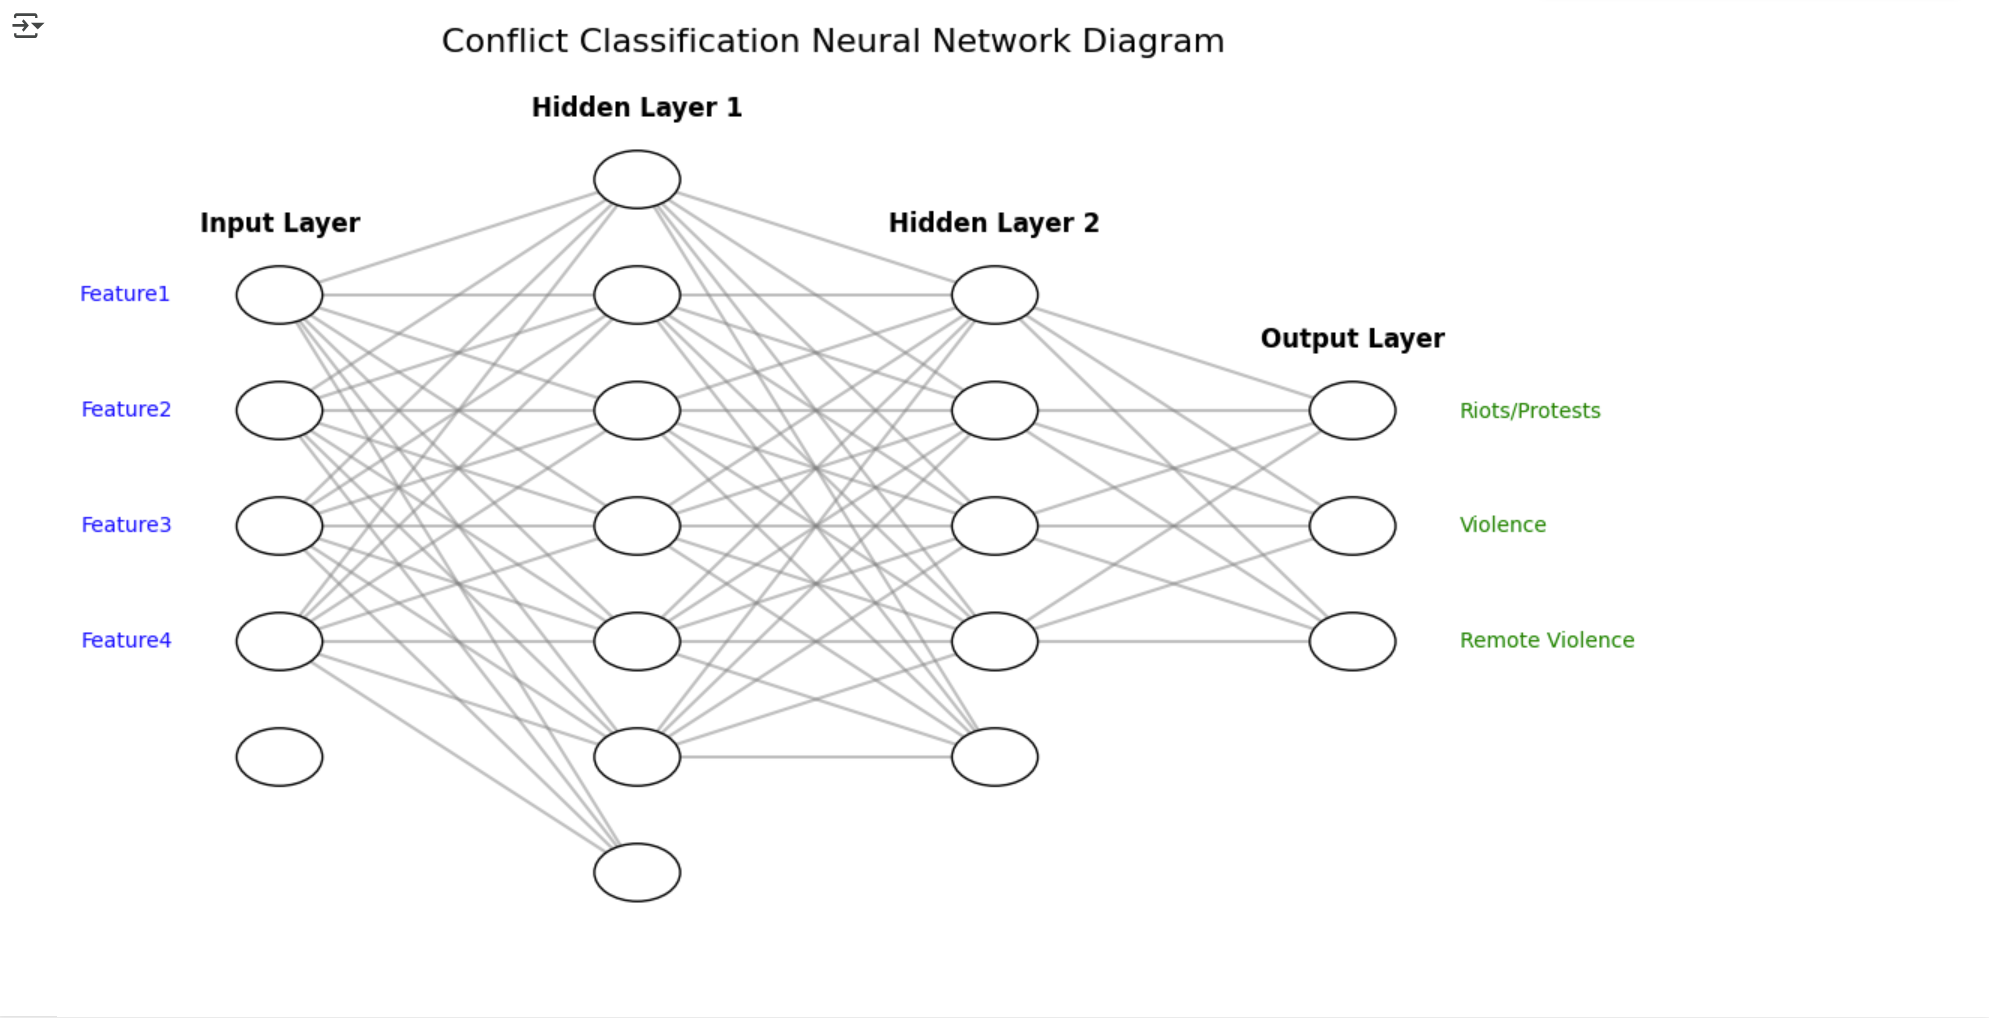

In [19]:
# SIMPLE NEURAL NETWORK (NO OPTIMIZATION)

# We do not specify any advanced hyperparameters or optimization
# techniques here. This is a baseline NN.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_simple_nn(input_dim, output_dim):
    model = Sequential()
    # Hidden layers (no dropout, no L2 regularization)
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))

    # Compile with default 'adam' optimizer, no specific hyperparameter tuning
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

simple_nn = build_simple_nn(X_train.shape[1], len(np.unique(y_train)))

history_simple = simple_nn.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate on validation set
val_loss_simple, val_acc_simple = simple_nn.evaluate(X_val, y_val, verbose=0)
print(f"\nSimple NN Validation Accuracy: {val_acc_simple:.4f}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2636/2636 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4514 - loss: 84.8732 - val_accuracy: 0.5921 - val_loss: 12.1266
Epoch 2/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5192 - loss: 13.3168 - val_accuracy: 0.6193 - val_loss: 9.8965
Epoch 3/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5350 - loss: 10.0352 - val_accuracy: 0.6154 - val_loss: 7.5560
Epoch 4/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5612 - loss: 7.0287 - val_accuracy: 0.6807 - val_loss: 4.1567
Epoch 5/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5863 - loss: 3.1057 - val_accuracy: 0.7070 - val_loss: 1.0652
Epoch 6/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6871 - loss: 1.0873 - val_accuracy: 0.6999 - val_loss: 1.0098
Epoch 7/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6871 - loss: 1.0535 - val_accuracy: 0.7045 - val_loss: 1.0200
Epoch 8/20
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6926 - loss: 1.0360 - val_

# 7: Single Optimized Neural Network

Let's now demonstrate how various optimization methods (optimizer choice, learning rate, dropout, L2, early stopping) can improve performance.

Early_stopping prevents overfitting by monitoring val_loss.

In [20]:
# SINGLE OPTIMIZED NEURAL NETWORK

# Here, we add techniques such as:
# 1. Dropout (regularization)
# 2. L2 regularization
# 3. EarlyStopping callback
# 4. Different optimizer (e.g., RMSprop)
# 5. Adjusted learning rate

def build_optimized_nn(
    input_dim,
    output_dim,
    optimizer='rmsprop',
    learning_rate=0.0001,
    dropout_rate=0.4,
    num_layers=3,
    l2_reg=0.0005
):
    model = Sequential()

    # First layer
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_reg), input_dim=input_dim))
    model.add(Dropout(dropout_rate))

    # Additional hidden layers
    for _ in range(num_layers - 1):
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(output_dim, activation='softmax'))

    # Choose optimizer
    if optimizer.lower() == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

optimized_nn = build_optimized_nn(
    input_dim=X_train.shape[1],
    output_dim=len(np.unique(y_train)),
    optimizer='rmsprop',
    learning_rate=0.0001,
    dropout_rate=0.4,
    num_layers=3,
    l2_reg=0.0005
)

history_optimized = optimized_nn.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on validation
val_loss_opt, val_acc_opt = optimized_nn.evaluate(X_val, y_val, verbose=0)
print(f"\nOptimized NN Validation Accuracy: {val_acc_opt:.4f}")



Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2636/2636 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.2191 - loss: 561.9904 - val_accuracy: 0.2661 - val_loss: 2.1027
Epoch 2/60
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2645 - loss: 3.5640 - val_accuracy: 0.2661 - val_loss: 1.8603
Epoch 3/60
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.2724 - loss: 2.4182 - val_accuracy: 0.2789 - val_loss: 1.7149
Epoch 4/60
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.2735 - loss: 1.9959 - val_accuracy: 0.2789 - val_loss: 1.6618
Epoch 5/60
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.2788 - loss: 1.8342 - val_accuracy: 0.2789 - val_loss: 1.6476
Epoch 6/60
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.2786 - loss: 1.7536 - val_accuracy: 0.2747 - val_loss: 1.6430
Epoch 7/60
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3037 - loss: 1.7012 - val_accuracy: 0.4853 - val_loss: 1.4314
Epoch 8/60
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3929 - loss: 1.5828 - val_acc

# 8: Five Instances of the Optimized Neural Network

This cell systematically trains five versions of the optimized NN, each with a unique hyperparameter setup.

The results are tabulated so you can compare which combination performs best.

In [12]:
# FIVE INSTANCES OF OPTIMIZED NN (VARYING HYPERPARAMETERS)

# Each instance will have different settings for:
# - Optimizer
# - Learning rate
# - Dropout
# - Number of layers
# - L2 regularization
# - EarlyStopping usage
# - Epochs

nn_instances = [
    {
        "name": "Instance 1 (Default)",
        "optimizer": "adam",
        "learning_rate": 0.001,
        "dropout_rate": 0.0,
        "num_layers": 2,
        "l2_reg": 0.0,
        "early_stopping": False,
        "epochs": 20
    },
    {
        "name": "Instance 2",
        "optimizer": "rmsprop",
        "learning_rate": 0.0005,
        "dropout_rate": 0.4,
        "num_layers": 3,
        "l2_reg": 0.001,
        "early_stopping": True,
        "epochs": 50
    },
    {
        "name": "Instance 3",
        "optimizer": "rmsprop",
        "learning_rate": 0.0005,
        "dropout_rate": 0.5,
        "num_layers": 3,
        "l2_reg": 0.001,
        "early_stopping": True,
        "epochs": 50
    },
    {
        "name": "Instance 4",
        "optimizer": "adam",
        "learning_rate": 0.001,
        "dropout_rate": 0.5,
        "num_layers": 4,
        "l2_reg": 0.001,
        "early_stopping": True,
        "epochs": 50
    },
    {
        "name": "Instance 5",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "dropout_rate": 0.4,
        "num_layers": 3,
        "l2_reg": 0.0005,
        "early_stopping": True,
        "epochs": 60
    },
]

def train_nn_instance(config):
    print(f"\nTraining {config['name']} ...")
    model = build_optimized_nn(
        input_dim = X_train.shape[1],
        output_dim = len(np.unique(y_train)),
        optimizer = config["optimizer"],
        learning_rate = config["learning_rate"],
        dropout_rate = config["dropout_rate"],
        num_layers = config["num_layers"],
        l2_reg = config["l2_reg"]
    )

    callbacks = []
    if config["early_stopping"]:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs = config["epochs"],
        batch_size = 32,
        validation_data = (X_val, y_val),
        callbacks = callbacks,
        verbose = 0  # Set to 1 for detailed logs
    )

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

    return {
        "Instance": config["name"],
        "Optimizer": config["optimizer"],
        "Learning Rate": config["learning_rate"],
        "Dropout Rate": config["dropout_rate"],
        "Num Layers": config["num_layers"],
        "L2 Reg": config["l2_reg"],
        "Early Stopping": "Yes" if config["early_stopping"] else "No",
        "Epochs": config["epochs"],
        "Val Loss": val_loss,
        "Val Accuracy": val_acc
    }

# Train all instances
results_list = [train_nn_instance(cfg) for cfg in nn_instances]

# Create a DataFrame of the results
instances_df = pd.DataFrame(results_list)
print("\nSummary of 5 Optimized NN Instances:")
print(instances_df)



Training Instance 1 (Default) ...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Instance 2 ...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Instance 3 ...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Instance 4 ...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Instance 5 ...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Summary of 5 Optimized NN Instances:
               Instance Optimizer  Learning Rate  Dropout Rate  Num Layers  \
0  Instance 1 (Default)      adam         0.0010           0.0           2   
1            Instance 2   rmsprop         0.0005           0.4           3   
2            Instance 3   rmsprop         0.0005           0.5           3   
3            Instance 4      adam         0.0010           0.5           4   
4            Instance 5      adam         0.0001           0.4           3   

   L2 Reg Early Stopping  Epochs  Val Loss  Val Accuracy  
0  0.0000             No      20  0.835832      0.742069  
1  0.0010            Yes      50  0.941905      0.701665  
2  0.0010            Yes      50  0.985103      0.698677  
3  0.0010            Yes      50  1.068408      0.670046  
4  0.0005            Yes      60  0.802982      0.755193  


# 9: Model Evaluation and Comparison

After hyperparameter tuning (via validation set), we do a final check on the test set.

This ensures an unbiased estimate of how well each model generalizes to unseen data.

In [21]:
# FINAL EVALUATION ON TEST SET

# Evaluate classical models on test set
test_acc_lr = accuracy_score(y_test, lr_model.predict(X_test))
test_acc_svm = accuracy_score(y_test, svm_model.predict(X_test))
test_acc_xgb = accuracy_score(y_test, xgb_model.predict(X_test))

# Evaluate neural network models
test_loss_simple, test_acc_simple = simple_nn.evaluate(X_test, y_test, verbose=0)
test_loss_opt, test_acc_opt = optimized_nn.evaluate(X_test, y_test, verbose=0)

# Print results
print("TEST ACCURACY:")
print(f" - Logistic Regression: {test_acc_lr:.4f}")
print(f" - SVM (subsampled):    {test_acc_svm:.4f}")
print(f" - XGBoost:             {test_acc_xgb:.4f}")
print(f" - Simple NN:           {test_acc_simple:.4f}")
print(f" - Optimized NN:        {test_acc_opt:.4f}")


TEST ACCURACY:
 - Logistic Regression: 0.6537
 - SVM (subsampled):    0.6589
 - XGBoost:             0.8604
 - Simple NN:           0.7576
 - Optimized NN:        0.7501


# 10: Saving and Loading Models

Persist the best models to disk so they can be reused later without retraining.

In [22]:
# SAVING THE BEST MODELS

os.makedirs('saved_models', exist_ok=True)

# Example: Save the best classical model (e.g., XGBoost if it performed best)
joblib.dump(xgb_model, 'saved_models/xgb_model.pkl')

# Example: Save the best optimized NN model
optimized_nn.save('saved_models/optimized_nn_model.h5')

print("Models saved successfully.")


Models saved successfully.


## A confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Classical Model (XGBoost) Performance:
Accuracy: 0.8603997723716034
Weighted F1 Score: 0.8377565457768092

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.05      0.09       459
           1       0.78      0.96      0.86      7729
           2       0.73      0.04      0.08       389
           3       0.66      0.22      0.33       151
           4       0.75      0.58      0.66       458
           5       0.63      0.26      0.37      1665
           6       0.97      0.99      0.98      7439
           7       0.79      0.63      0.70      1929
           8       0.89      0.94      0.91      7897

    accuracy                           0.86     28116
   macro avg       0.77      0.52      0.55     28116
weighted avg       0.85      0.86      0.84     28116



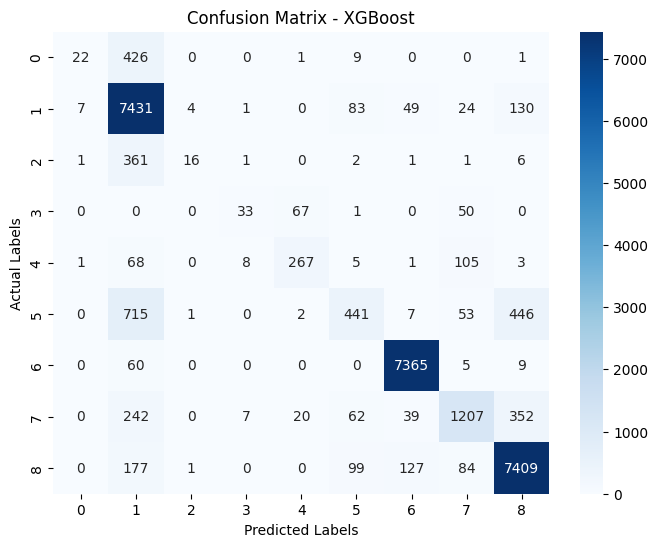

879/879 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Neural Network (Optimized NN) Performance:
Accuracy: 0.7501067008109261
Weighted F1 Score: 0.6964926619007229

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       459
           1       0.71      0.79      0.75      7729
           2       0.00      0.00      0.00       389
           3       0.00      0.00      0.00       151
           4       0.39      0.17      0.24       458
           5       0.00      0.00      0.00      1665
           6       0.80      0.97      0.88      7439
           7       0.57      0.21      0.31      1929
           8       0.76      0.93      0.83      7897

    accuracy                           0.75     28116
   macro avg       0.36      0.34      0.33     28116
weighted avg       0.67      0.75      0.70     28116



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


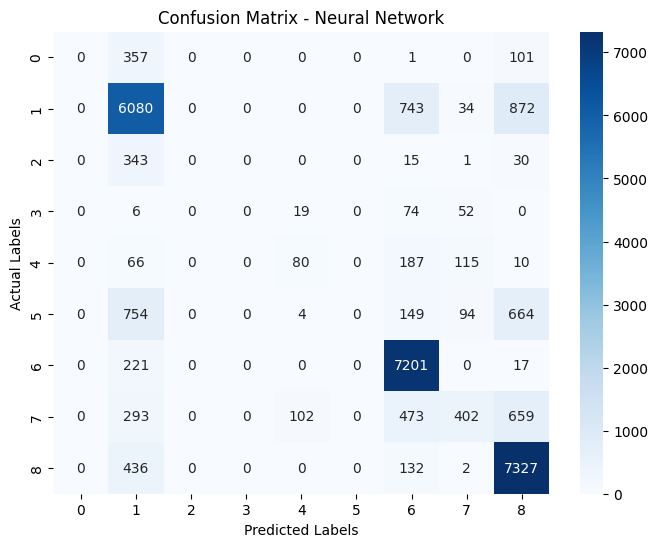

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score


# Evaluate Classical Model (XGBoost)

# Predict on the test set using the classical model
pred_classical = xgb_model.predict(X_test)
acc_classical = accuracy_score(y_test, pred_classical)
f1_classical = f1_score(y_test, pred_classical, average='weighted')
cm_classical = confusion_matrix(y_test, pred_classical)

print("Classical Model (XGBoost) Performance:")
print("Accuracy:", acc_classical)
print("Weighted F1 Score:", f1_classical)
print("\nClassification Report:")
print(classification_report(y_test, pred_classical))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_classical, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()


# Evaluate Neural Network Model (Optimized NN)

# Predict on the test set using the neural network
predictions_nn = optimized_nn.predict(X_test)
pred_nn = predictions_nn.argmax(axis=1)
acc_nn = accuracy_score(y_test, pred_nn)
f1_nn = f1_score(y_test, pred_nn, average='weighted')
cm_nn = confusion_matrix(y_test, pred_nn)

print("Neural Network (Optimized NN) Performance:")
print("Accuracy:", acc_nn)
print("Weighted F1 Score:", f1_nn)
print("\nClassification Report:")
print(classification_report(y_test, pred_nn))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()


# 11: Making Predictions

1. This cell shows how to load the saved models and perform inference on new data (or a sample from the test set).

2. For neural networks, we convert probability distributions to class indices using argmax.

In [24]:
# MAKING PREDICTIONS WITH SAVED MODELS

# 1. Classical Model (XGBoost)
best_classical = joblib.load('saved_models/xgb_model.pkl')
# Suppose we want to predict on the first 5 samples of the test set
X_test_sample = X_test.iloc[:5]
pred_classical = best_classical.predict(X_test_sample)
print("XGBoost Predictions:", pred_classical)

# 2. Neural Network Model
best_nn_model = load_model('saved_models/optimized_nn_model.h5')
predictions_nn = best_nn_model.predict(X_test_sample)
predicted_classes_nn = predictions_nn.argmax(axis=1)
print("Optimized NN Predictions (class indices):", predicted_classes_nn)

# (Optional) Decode predictions back to original labels if needed
decoded_classical = label_encoders['EVENT_TYPE'].inverse_transform(pred_classical)
decoded_nn = label_encoders['EVENT_TYPE'].inverse_transform(predicted_classes_nn)
print("Decoded XGBoost Predictions:", decoded_classical)
print("Decoded NN Predictions:", decoded_nn)


XGBoost Predictions: [6 6 6 5 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Optimized NN Predictions (class indices): [6 6 6 1 8]
Decoded XGBoost Predictions: ['Riots/Protests' 'Riots/Protests' 'Riots/Protests' 'Remote violence'
 'Violence against civilians']
Decoded NN Predictions: ['Riots/Protests' 'Riots/Protests' 'Riots/Protests'
 'Battle-No change of territory' 'Violence against civilians']


# **12: Summary**

1. **Classical vs. Neural Networks:**  
   - The classical models (Logistic Regression, SVM, XGBoost) provide quick baselines and can be quite powerful, especially XGBoost for structured data.  
   - Neural networks can offer additional flexibility but often require careful tuning (e.g., dropout, L2 regularization, learning rate, and optimizer choice).

2. **Five Instances Analysis:**  
   - The table of five instances shows how different hyperparameter combinations (e.g., Adam vs. RMSProp, dropout rates, and early stopping) impact performance.  
   - From the validation accuracy in `instances_df`, we can see which combination performed the best.  
   - That best model can be tested on the hold-out test set for final performance metrics.


Congratulations!!


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression - Accuracy: 0.65, Precision: 0.55, Recall: 0.65, F1-Score: 0.59


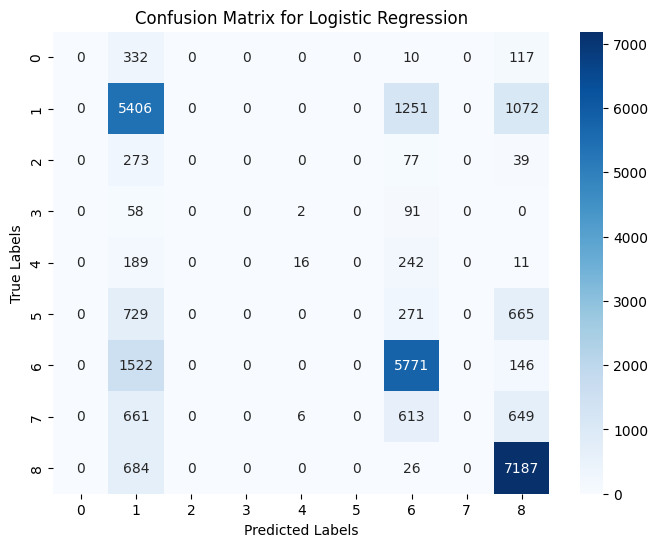

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM - Accuracy: 0.66, Precision: 0.56, Recall: 0.66, F1-Score: 0.60


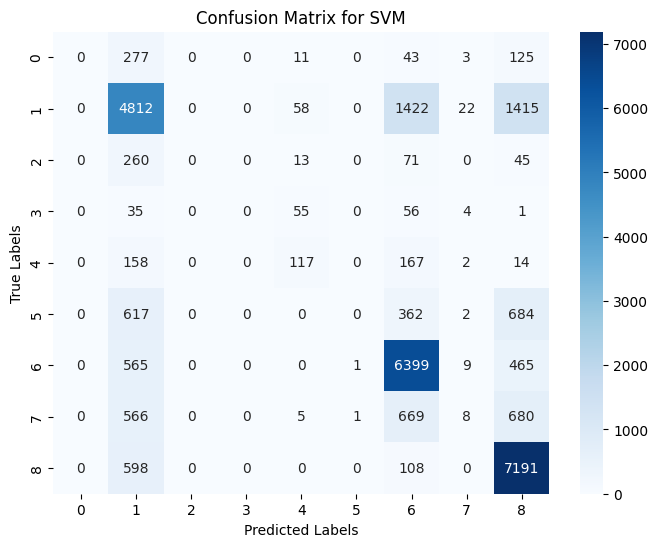

XGBoost - Accuracy: 0.86, Precision: 0.85, Recall: 0.86, F1-Score: 0.84


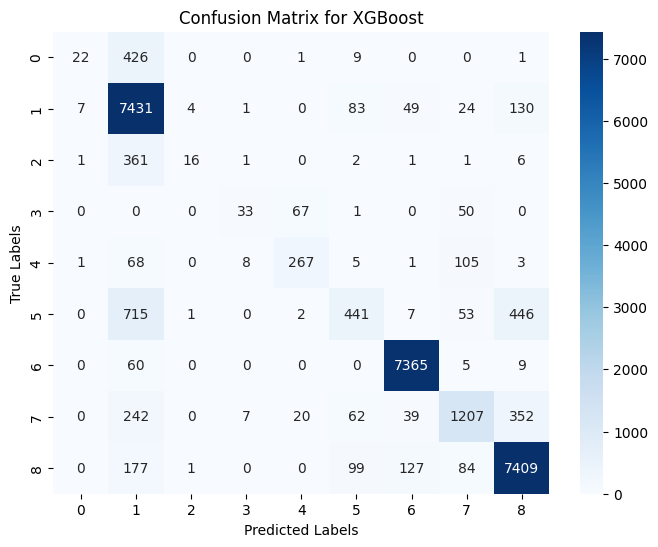

879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Simple Neural Network - Accuracy: 0.76, Precision: 0.67, Recall: 0.76, F1-Score: 0.71


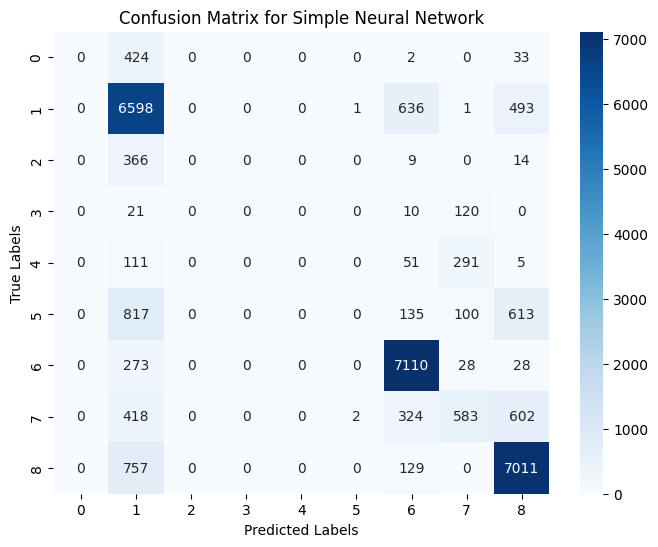

879/879 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Optimized Neural Network - Accuracy: 0.75, Precision: 0.67, Recall: 0.75, F1-Score: 0.70


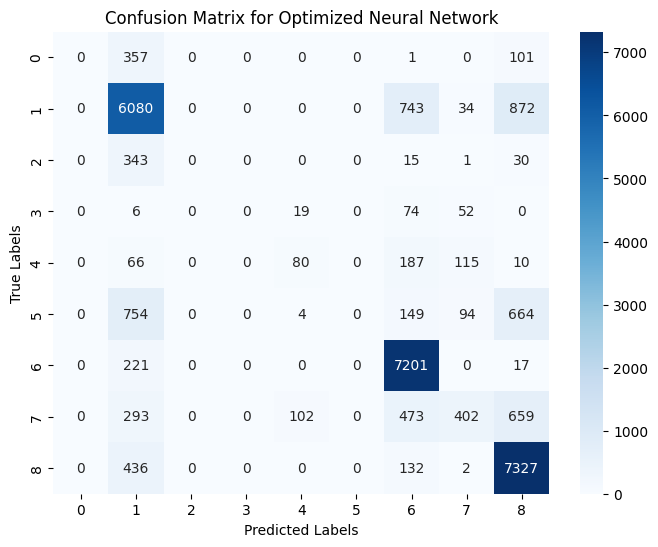

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.utils import plot_model

# Evaluate all models
def evaluate_model(model, X, y, model_name='Model'):
    predictions = model.predict(X)
    # Check if predictions are 2D (probabilities from NN) or 1D (class indices)
    if predictions.ndim == 2:  # If 2D, get class indices
        predictions = predictions.argmax(axis=1)

    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions, average='weighted')
    recall = recall_score(y, predictions, average='weighted')
    f1 = f1_score(y, predictions, average='weighted')

    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    # Plotting confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return accuracy, precision, recall, f1

# Evaluations
metrics = {}
metrics['Logistic Regression'] = evaluate_model(lr_model, X_test, y_test, 'Logistic Regression')
metrics['SVM'] = evaluate_model(svm_model, X_test, y_test, 'SVM')
metrics['XGBoost'] = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')
metrics['Simple NN'] = evaluate_model(simple_nn, X_test, y_test, 'Simple Neural Network')
metrics['Optimized NN'] = evaluate_model(optimized_nn, X_test, y_test, 'Optimized Neural Network')
